In [1]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import math 
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.rc("figure", figsize=(18,5))

/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def Dickey_Fuller_test(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    Dickey_Fuller_test(timeseries)
    
def plot_residuals(df):
    # plot residual erros
    residuals = pd.DataFrame(df)
    residuals.plot()
    residuals.plot(kind='kde')
    print(residuals.describe())
    (residuals*residuals).plot()
    plot_correlation(residuals*residuals)
    
def plot_correlation(data):
    plot_acf(data,lags=20)
    plt.show()
    plot_pacf(data,lags=20)
    plt.show()

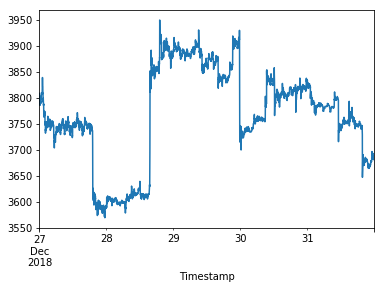

In [8]:
# Učitavanje podataka. Kao dataset sam uzeo zadnjih 7200 minuta ili zadnjih 8 dana
data = pd.read_pickle("/home/filip/Desktop/Ruđer/FinalData/distinct.pkl")
data = data.set_index("Timestamp")
data = data["Price"].tail(7200)
data.plot()

In [70]:
# Vremenska serija nije stacionarna p>0.05
Dickey_Fuller_test(data.tail(1000))

Results of Dickey-Fuller Test:
Test Statistic                  -1.380811
p-value                          0.591440
#Lags Used                       2.000000
Number of Observations Used    997.000000
Critical Value (1%)             -3.436926
Critical Value (5%)             -2.864443
Critical Value (10%)            -2.568316
dtype: float64


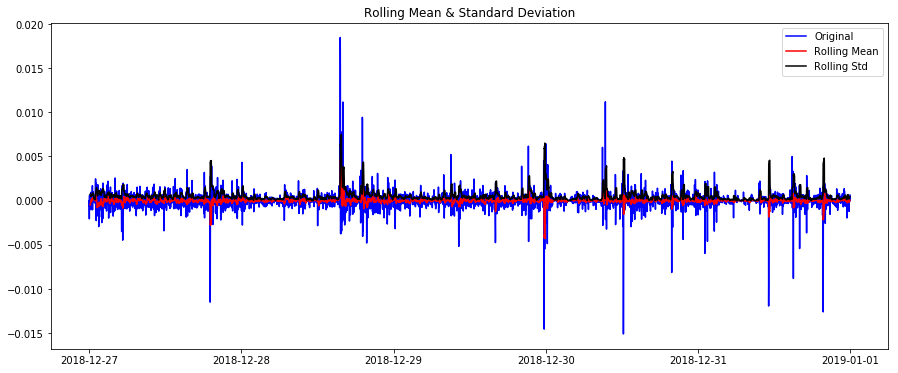

Results of Dickey-Fuller Test:
Test Statistic                  -34.038132
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    7194.000000
Critical Value (1%)              -3.431259
Critical Value (5%)              -2.861942
Critical Value (10%)             -2.566984
dtype: float64


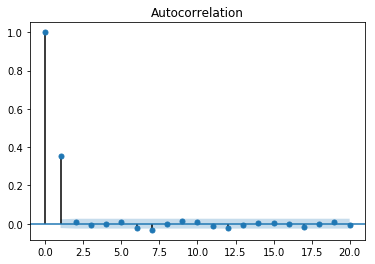

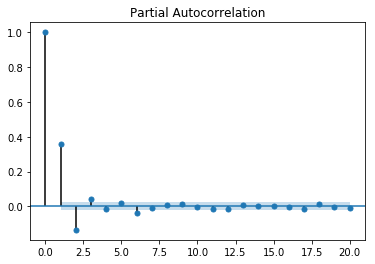

In [9]:
# Transformiramo vremensku seriju u stacionarni oblik. Nakon transformacije u postotnu promjenu 
# vremenska serija postaje stacionarana p<0.05.
data = data.pct_change()
data = data.replace([np.inf, -np.inf], np.nan)
data = data.fillna(0)
test_stationarity(data)
plot_correlation(data)

In [10]:
# Razdvajamo podatke u train i test set
train = data[:-30]
print(train.replace([np.inf, -np.inf], np.nan).isnull().sum())
train = train.fillna(0)
test = data[-30:]
print(test.replace([np.inf, -np.inf], np.nan).isnull().sum())
test = test.fillna(0)

0
0


In [11]:
# Funkcija koja vraća najbolji model. Uzima se zbroj bica i aica
def get_best_model(TS):
    best = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(6) # [0,1,2,3,4]
    d = 0
    qq_rng = range(5)
    for i in pq_rng:
        for j in qq_rng:
            try:
                tmp_mdl = ARIMA(TS, order=(i,d,j)).fit(
                    method='mle', trend='nc', freq="T"
                )
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic
                if tmp_aic+tmp_bic < best:
                    best_aic = tmp_aic
                    best_bic = tmp_bic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
                    print("best:",i,d,j)
            except: continue
        print(i,d,j)
    print('aic: {:6.2f} | order: {}'.format(best_aic,best_bic, best_order))                    
    return best_aic, best_order, best_mdl

In [12]:
res_tup = get_best_model(train)
model = res_tup[2]
order = res_tup[1]
p_ = order[0]
o_ = order[1]
q_ = order[2]
print(res_tup[2].summary())

/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provide

best: 0 0 1
best: 0 0 2
best: 0 0 3
best: 0 0 4
0 0 4
best: 1 0 0


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 1 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 1 0 2


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 1 0 4
1 0 4
best: 2 0 0


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 2 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


2 0 4
best: 3 0 0


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 3 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


3 0 4
best: 4 0 0


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 4 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 4 0 2


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


4 0 4
best: 5 0 0


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 5 0 1


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 5 0 2


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


best: 5 0 3


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


5 0 4
aic: -81022.78 | order: -80960.87994284701
                              ARMA Model Results                              
Dep. Variable:                  Price   No. Observations:                 7170
Model:                     ARMA(5, 3)   Log Likelihood               40520.389
Method:                           mle   S.D. of innovations              0.001
Date:                Mon, 02 Sep 2019   AIC                         -81022.779
Time:                        12:48:28   BIC                         -80960.880
Sample:                    12-27-2018   HQIC                        -81001.475
                         - 12-31-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.Price     0.3499      0.109      3.198      0.001       0.135       0.564
ar.L2.Price    -0.6797      0.118     -5.749      0.000      -0.911      -0.448

                 0
count  7170.000000
mean     -0.000027
std       0.008500
min      -0.143013
25%      -0.001783
50%       0.000013
75%       0.001788
max       0.157076


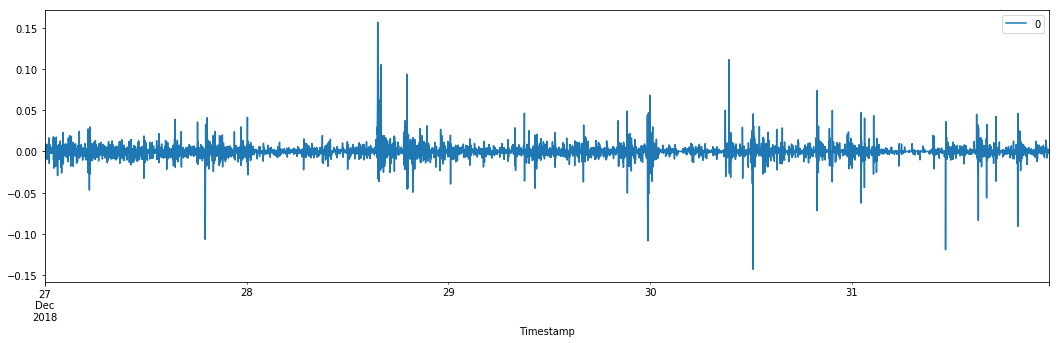

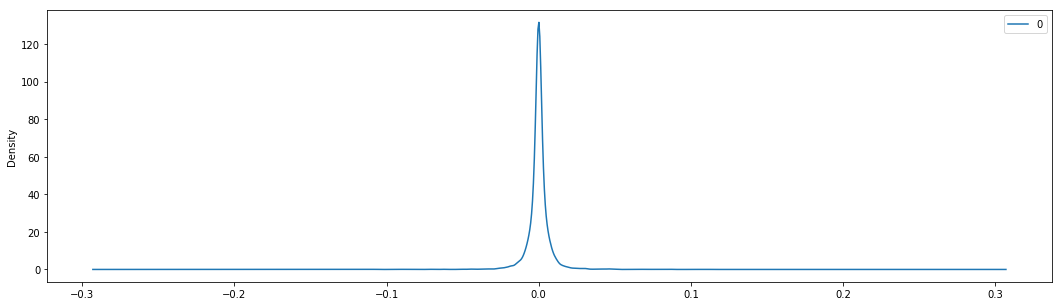

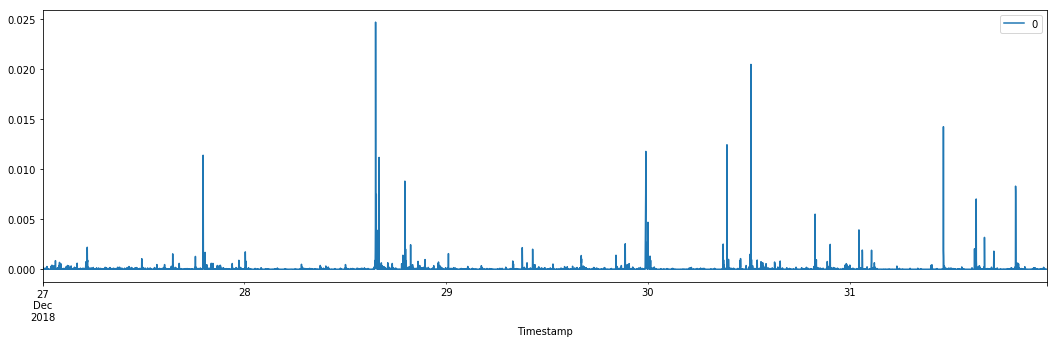

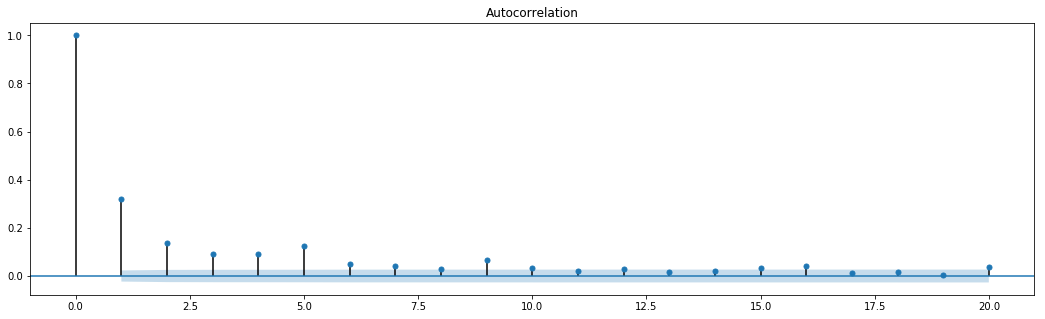

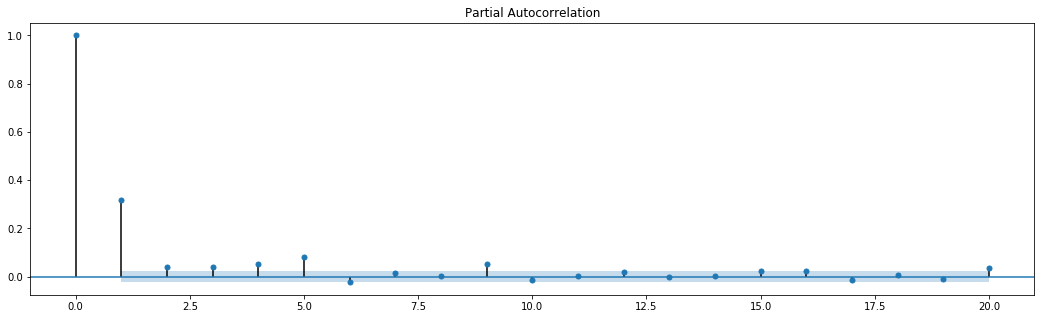

In [75]:
# Plotanje residualsa radi provjere dali jos uvijek postoji korelacija. Traži se da ostatci izgledaju poput
# bijelog šuma. Ovdje nije dobiven taj rezultat što znači da model ima neki nedostatak. Arima je najvjerojatnije
# pre jednostavan za ovaj dataset.
plot_residuals(model.resid)

In [13]:
# Pokušaj treniranja GARCH modela na residualnoj vremenskoj seriji
am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:     13,   Neg. LLF: -44398.99149995179
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -44398.991504224774
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1


/home/filip/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                44399.0
Distribution:      Standardized Student's t   AIC:                          -88776.0
Method:                  Maximum Likelihood   BIC:                          -88700.3
                                              No. Observations:                 7170
Date:                      Mon, Sep 02 2019   Df Residuals:                     7159
Time:                              12:48:32   Df Model:                           11
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

              resid
count  7.170000e+03
mean  -1.973717e-20
std    8.500098e-04
min   -1.429850e-02
25%   -1.755654e-04
50%    4.072196e-06
75%    1.815594e-04
max    1.571035e-02


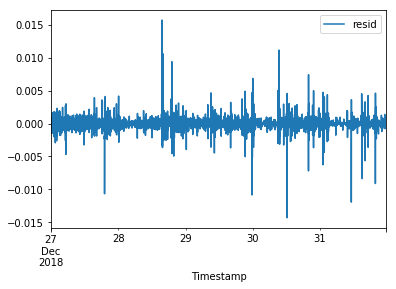

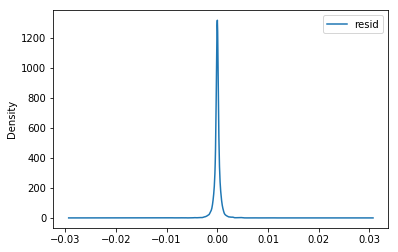

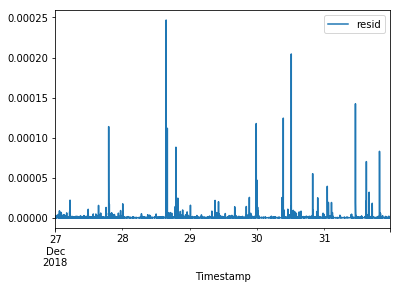

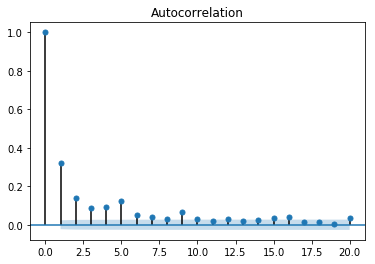

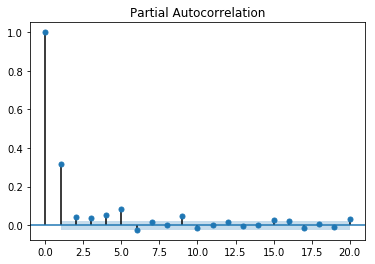

In [14]:
# Model nije ništa naučio....
plot_residuals(res.resid)

In [ ]:
train.loc[train]

In [15]:
# Treniranje i predikcija rezultata za idući dan
history = [x for x in train]
history = history
print(len(test))
predictions = []
for t in range(len(test)):
    obs = test[t]
    #Arima model fitting
    model = ARIMA(history, order=(p_,o_,q_))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    
    #Results
    residuals = model_fit.resid
    yhat = output[0]
    
    #Appending results
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

30


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000089, expected=-0.000890


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000333, expected=-0.001959
predicted=-0.000696, expected=-0.000071


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.000230, expected=0.000391
predicted=0.000068, expected=0.000029


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000044, expected=0.000154


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.000058, expected=0.000526
predicted=0.000234, expected=0.000159
predicted=-0.000002, expected=0.000411


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.000156, expected=0.000169
predicted=-0.000024, expected=-0.000119


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000038, expected=-0.000078


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000014, expected=-0.000422
predicted=-0.000152, expected=-0.000096
predicted=0.000003, expected=-0.000019


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000021, expected=-0.000090


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000044, expected=-0.000027
predicted=0.000012, expected=-0.000080


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000024, expected=0.000074
predicted=0.000033, expected=-0.000039
predicted=-0.000057, expected=-0.001213


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000493, expected=0.000226


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.000275, expected=0.000335


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.000049, expected=-0.000161
predicted=-0.000083, expected=0.000327


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=0.000142, expected=0.000505


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted=0.000172, expected=0.000027


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=-0.000058, expected=-0.000001
predicted=0.000018, expected=0.000000
predicted=-0.000008, expected=0.000626


/home/filip/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Test MSE: 0.0000002325


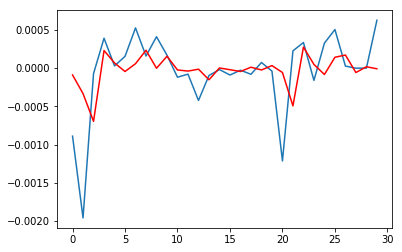

In [16]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.10f' % error)
plt.plot(test.values)
plt.plot(predictions, color='red')